<a href="https://colab.research.google.com/github/Damelim/ESC20-SPRING/blob/master/Week2_Linear_Basis_Regression_damelim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week2 Linear Basis Regression

### Made by Hunlearning

### Editted by Damian Lim

이번주는 시험으로 인해 필수적인 부분만 코드도 딱 필요한 정도로만 넣었는데 다음부터는 더욱 창의적인 결과물이 나올 것입니다

In [0]:
import numpy as np; np.set_printoptions(precision=3)
import pandas as pd; pd.set_option('display.precision',3)
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import files #google colab에서 R의 file.choose()와 같은 기능

uploaded = files.upload()

Saving real.csv to real (3).csv


## 0. Exploratoy Data Analysis

#### 오늘 준비한 데이터는 2012~2013년 타이완 부동산 거래가격 데이터입니다!

### 1) 먼저 데이터를 읽어주고

In [0]:
real = pd.read_csv('real.csv', index_col=0)
real.columns = ['date','house_age','dist_mrt','no_cvs','lat','long','price']
real.info() # No NA value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       414 non-null    float64
 1   house_age  414 non-null    float64
 2   dist_mrt   414 non-null    float64
 3   no_cvs     414 non-null    int64  
 4   lat        414 non-null    float64
 5   long       414 non-null    float64
 6   price      414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


### 2) Glimpse at the data


In [0]:
real.head(5)

,date,house_age,dist_mrt,no_cvs,lat,long,price
No,,,,,,,
1,2012.917,32.0,84.879,10,24.983,121.540,37.9
2,2012.917,19.5,306.595,9,24.980,121.540,42.2
3,2013.583,13.3,561.985,5,24.987,121.544,47.3
4,2013.500,13.3,561.985,5,24.987,121.544,54.8
5,2012.833,5.0,390.568,5,24.979,121.542,43.1


#### 나중에 그림 그릴거 생각해서 거래가 기준으로 짜라락 정렬하자

In [0]:
real.sort_values(by=['price'], inplace=True)
real.reset_index(inplace=True) # inplace: replace the original dataset
real = real.drop(['No'], axis=1) #colwise
real.head()


,date,house_age,dist_mrt,no_cvs,lat,long,price
0,2013.333,14.8,393.261,6,24.962,121.538,7.6
1,2013.583,17.4,6488.021,1,24.957,121.474,11.2
2,2012.750,16.0,4066.587,0,24.943,121.503,11.6
3,2013.000,30.9,6396.283,1,24.944,121.479,12.2
4,2013.083,32.0,1156.777,0,24.949,121.530,12.8


In [0]:
real.tail()

,date,house_age,dist_mrt,no_cvs,lat,long,price
409,2012.833,0.0,292.998,6,24.977,121.545,71.0
410,2013.417,0.0,292.998,6,24.977,121.545,73.6
411,2013.583,35.4,318.529,9,24.971,121.541,78.0
412,2013.333,37.2,186.510,9,24.977,121.543,78.3
413,2013.333,10.8,252.582,1,24.975,121.530,117.5


### 3) 거래가가 넘사벽인게 있네 이런건 Outlier로 지워줍시다

In [0]:
real.describe()

,date,house_age,dist_mrt,no_cvs,lat,long,price
count,414.000,414.000,414.000,414.000,414.000,414.000,414.000
mean,2013.149,17.713,1083.886,4.094,24.969,121.533,37.980
std,0.282,11.392,1262.110,2.946,0.012,0.015,13.606
min,2012.667,0.000,23.383,0.000,24.932,121.474,7.600
25%,2012.917,9.025,289.325,1.000,24.963,121.528,27.700
50%,2013.167,16.100,492.231,4.000,24.971,121.539,38.450
75%,2013.417,28.150,1454.279,6.000,24.977,121.543,46.600
max,2013.583,43.800,6488.021,10.000,25.015,121.566,117.500


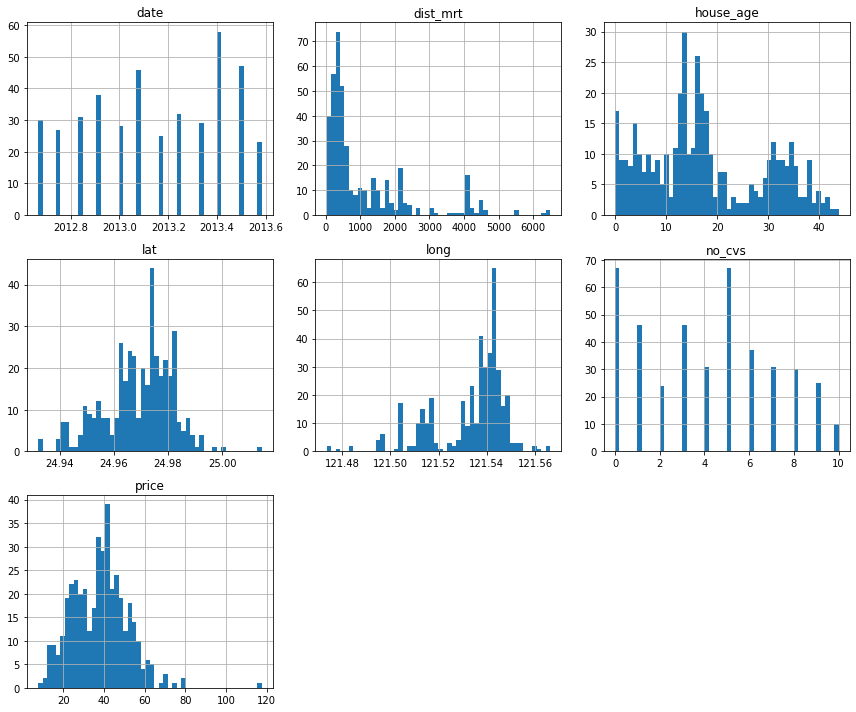

In [0]:
real.hist(bins=50, figsize=(12,10))
plt.tight_layout()

In [0]:
np.percentile(real.price, 99.5)

77.71400000000001

In [0]:
real.price<80 #col boolean vec

0       True
1       True
2       True
3       True
4       True
       ...  
409     True
410     True
411     True
412     True
413    False
Name: price, Length: 414, dtype: bool

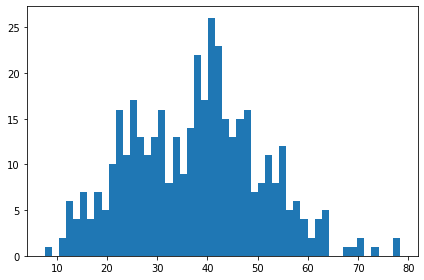

In [0]:
real = real[real.price < 80]
plt.hist(real.price, bins=50)
plt.tight_layout()

### 4) 변수 간의 관계 살펴보기 / 변환 해야할까 결정하기

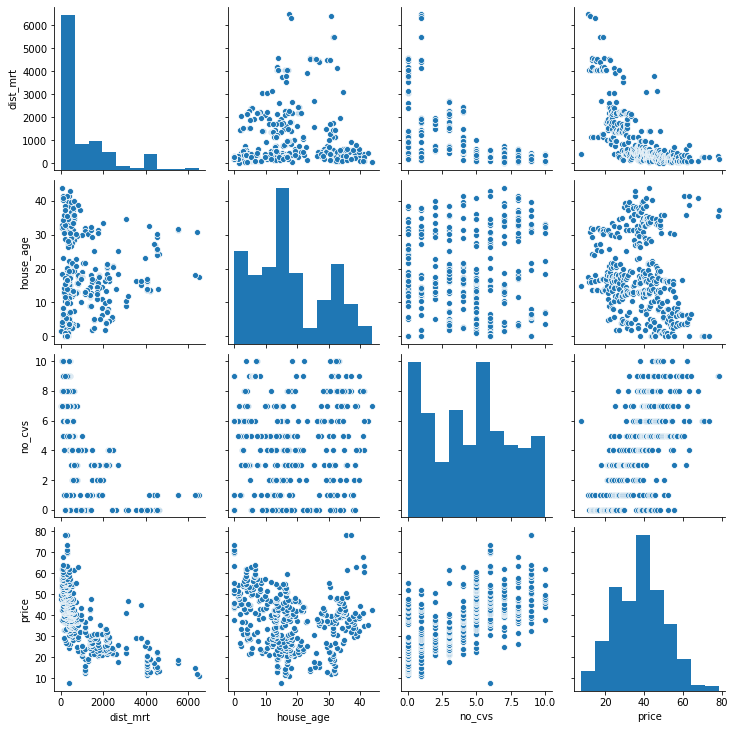

In [0]:
sns.pairplot(real[['dist_mrt', 'house_age','no_cvs','price']])

#### 지하철 역과의 거리의 분포가 상당히 skewed되고, 단위도 큽니다. 어떻게 할까요?

사실 Linear Basis Function Model의 가정에 따르면 잔차의 분포가 종모양이기만 하면 되기 때문에 설명변수와 그 feature의 분포가 종 모양일 필요도 없으며, 단위도 어차피 나중에 표준화할 것이다. 설명변수에 변환을 취하는 경우는 만일 변환의 결과로 종속변수와의 숨겨져있던 관계(선형이든 뭐든)가 보일 때(라고 생각하지만 언제든 반론은 환영합니다)이다. 

하지만 skew의 정도가 너무 심하면 데이터의 산점도를 볼 때 직관적인 파악이 어려우며, high-dimensional 데이터의 경우도 다른 설명변수들이 종 모양일때 혼자만 skew가 되어있으면 변수끼리 비교가 힘들다. 무엇보다도 대부분의 머신러닝 알고리즘에선s feature의 표준화를 전제로 하기 때문에, 데이터 분포가 종 모양이어야 표준화가 제대로 된다. 그러니 결론은 __skew된 설명변수는 왠만하면 종모양으로 만들어주자__.

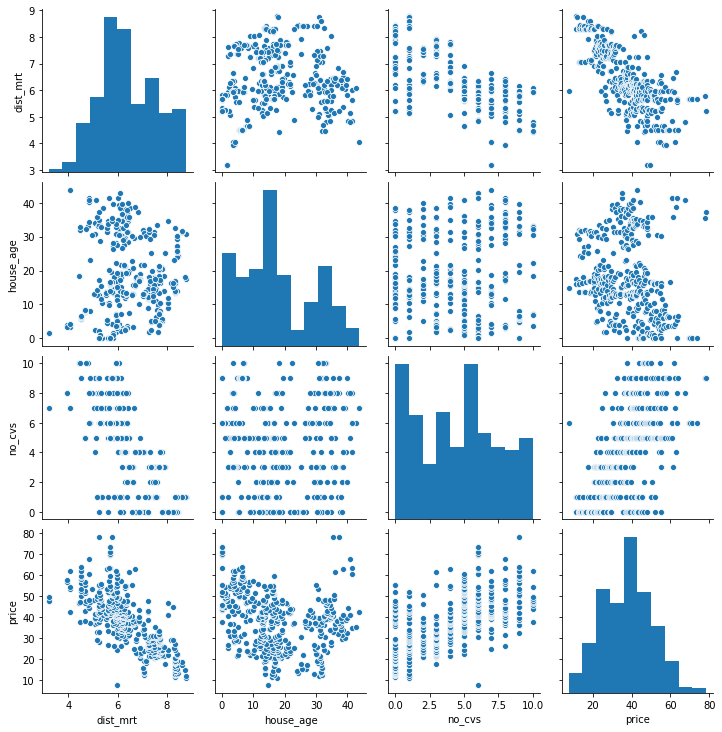

In [0]:
real2 = real.copy()
real2['dist_mrt'] = np.log(1+real.dist_mrt) # to prevent inf
sns.pairplot(real2[['dist_mrt', 'house_age','no_cvs','price']])

이 경우 dist_mist에 로그를 취했더니 이쁘게 선형 관계가 나왔다. 산점도만 보면 거래가는 거리와는 선형관계, 집 연식과는 뭔가 2차원 곡선같은 관계, 그리고 편의점 개수와는 완만한 선형관계가 보인다. 이런 인사이트를 데이터 분석으로 한번 확인해보자.

### Plot 3 dim plot


In [0]:
# https://plotly.com/python/3d-scatter-plots/
import plotly.express as px
fig = px.scatter_3d(real2, x='dist_mrt', y='no_cvs', z='house_age',
                   color='price')
fig.update_traces(marker=dict(size=6,
                              line=dict(width=2,color='DarkSlateGrey')))
fig.show()

(이런 것도 그릴 수는 있긴 있는데 어차피 High-dimensional에서는 산점도 따위 어림도 없으니 그냥 참고만 하고 넘어가자)

### 부록) 세션 주제와 상관 없지만 공간 데이터니까 한번 시각화를 해보자

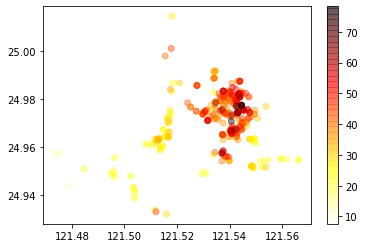

In [0]:
fig, ax = plt.subplots()
scatter = ax.scatter(real.long, real.lat, 
            c=real.price, cmap='hot_r', alpha=0.4)
fig.colorbar(scatter)

뭔가 밋밋한데...

### Geopanda로 shapefile불러와 지도 그리기!

필요한 모듈: geopandas, shapely, descartes. 아나콘다에서 쉽게 설치할 수 있음

이런거 다 어디서 배워요? 구골


## (2) Feature Extraction

거래가 분석에 위도랑 경도는 저런 지도 그리는거 말고는 쓸데없다. 이제 실전 데이터 분석을 해보자. 지금부터는 train_set에 대해서만 얘기한다. 세션 주제 중 Feature Extraction을 해본다. 시각화를 위해 설명변수는 2개만 가져온다.

In [0]:
data = real2[['dist_mrt', 'house_age','price']]

## Q1. Train-Test Split

그냥 sklearn에서 train_test_split쓰는게 제일 간단. 그러나 __DataFrame으로 데이터를 저장했다면 reset_index를 꼭 해줘야 함!__ 



** 일반 코드 먼저


In [0]:
N = data.shape[0] # number of rows!
test = np.random.choice(np.arange(N), int(N*0.2), replace=False)
test_df = data[data.index.isin(test)].copy()
train_df = data[~data.index.isin(test)].copy()
print(train_df.shape, test_df.shape)

X_train = train_df[['dist_mrt', 'house_age']]
Y_train = train_df['price']
X_test = test_df[['dist_mrt', 'house_age']]
Y_test = test_df['price']

X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
data.head()

(331, 3) (82, 3)


,dist_mrt,house_age,price
0,5.977,14.8,7.6
1,8.778,17.4,11.2
2,8.311,16.0,11.6
3,8.764,30.9,12.2
4,7.054,32.0,12.8


**sklearn package!**


https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [0]:
from sklearn.model_selection import train_test_split
#First need to split X(predictor) and y(response) by hand

X= data.loc[:,data.columns!='price'] ; y = data.loc[:,data.columns=='price'] #.loc 

#Second, use arguments of t.. t.. s.. function
X_train , X_test, y_train, y_test= train_test_split(X,y,test_size = 0.2)
print(X_train.index)
print(y_train.index)
X_train.head()


Int64Index([235, 149,  93, 126, 178, 131, 151, 332, 303,  61,
            ...
            105,   9, 127,  71, 163,  86, 362, 282, 184,  45],
           dtype='int64', length=330)
Int64Index([235, 149,  93, 126, 178, 131, 151, 332, 303,  61,
            ...
            105,   9, 127,  71, 163,  86, 362, 282, 184,  45],
           dtype='int64', length=330)


,dist_mrt,house_age
235,6.204,32.6
149,5.142,12.7
93,7.255,18.0
126,7.216,12.2
178,6.564,22.8


Problem here : Index all over the place ->reset_index!!!

In [0]:
X_train.reset_index(drop = True, inplace= True)
X_test.reset_index(drop = True, inplace= True)
y_train.reset_index(drop = True, inplace= True)
y_test.reset_index(drop = True, inplace= True)
X_train.head()


,dist_mrt,house_age
0,6.204,32.6
1,5.142,12.7
2,7.255,18.0
3,7.216,12.2
4,6.564,22.8


Now the indices are cleanly arranged!

### 2) Feature-scaling

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [0]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train) #standardize to make it mean 0, sd 1
type(scaler)

sklearn.preprocessing._data.StandardScaler

In [0]:
def Scl_train(sclr, df):
    colnames = df.columns
    df = sclr.transform(df)
    df = pd.DataFrame(df)
    df.set_axis(colnames, axis=1, inplace=True)
    return df

이렇게 해줘야지 나중에 scaler.transform으로 train set에 했던 스케일링을 test set에 고대로 해줄 수 있다.

In [0]:
X_train_sc = Scl_train(scaler, X_train)
print(np.mean(X_train_sc), np.var(X_train_sc)) #correctly scaled!
X_train_sc.head()

dist_mrt    -4.185e-16
house_age    9.286e-17
dtype: float64 dist_mrt     1.0
house_age    1.0
dtype: float64


,dist_mrt,house_age
0,-0.134,1.262e+00
1,-1.090,-4.570e-01
2,0.814,8.901e-04
3,0.778,-5.002e-01
4,0.190,4.156e-01


In [0]:
#now, test data
X_test_sc = Scl_train(scaler, X_test)
X_test_sc.describe()

,dist_mrt,house_age
count,83.000,83.000
mean,0.200,-0.112
std,1.015,0.917
min,-1.686,-1.554
25%,-0.602,-0.729
50%,-0.064,-0.206
75%,0.985,0.303
max,2.185,2.022


# using the variable ax for single a Axes
fig, ax = plt.subplots()

# using the variable axs for multiple Axes
fig, axs = plt.subplots(2, 2)

# using tuple unpacking for multiple Axes
fig, (ax1, ax2) = plt.subplot(1, 2)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplot(2, 2)

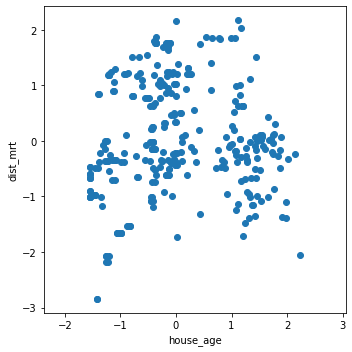

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_train_sc.house_age, X_train_sc.dist_mrt)
ax.set_xlabel('house_age')
ax.set_ylabel('dist_mrt')
ax.axis('equal') #aspect ratio set equal
fig.tight_layout()

In [0]:
import plotly.express as px
fig = px.scatter_3d(x=X_train_sc.dist_mrt, y=X_train_sc.house_age, z=y_train)
fig.update_traces(marker=dict(size=4,
                              line=dict(width=0.1,
                                        color='DarkSlateGrey')))

fig.show()

## (3) Linear Basis Model Fitting

## Q2) Polynomial Basis Fitting

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [0]:
def Poly_Reg(X_train, Y_train, X_test, Y_test, m, fig=False):
    # Feature Extraction
    poly = PolynomialFeatures(degree=m)  #make features
  #If there're many predictors(x1,x2), create 1,x1,x2,x1^2, x2^2,x1x2
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    # LR Fitting
    lin = LinearRegression(fit_intercept=False)
    lin.fit(X_train_poly, Y_train)
    Y_train_pred = lin.predict(X_train_poly)
    Y_test_pred = lin.predict(X_test_poly)

    # Compue MSE
    train_MSE = np.sqrt(np.linalg.norm(Y_train - Y_train_pred)**2/Y_train.shape[0])
    test_MSE = np.sqrt(np.linalg.norm(Y_test - Y_test_pred)**2/Y_test.shape[0])

    # Visualize
    if fig is True:
        fig = px.scatter_3d(x=X_train.dist_mrt, y=X_train.house_age, z=Y_train_pred)
        fig.update_traces(marker=dict(size=4,
                                  line=dict(width=0.1,
                                            color='DarkSlateGrey')))
        fig.show()
    
    # Residual
    Resid = Y_train - Y_train_pred
    
    return {'coef':lin.coef_, 'train_MSE':train_MSE, 'test_MSE':test_MSE, 'Resid':Resid}

In [0]:
PRmodel = Poly_Reg(X_train_sc, y_train, X_test_sc, y_test, 2, fig=True)
PRmodel

{'Resid':       price
 0     2.711
 1   -14.137
 2    -3.261
 3    -1.992
 4     1.497
 ..      ...
 325  -0.552
 326   8.362
 327   2.213
 328  -0.177
 329 -12.791
 
 [330 rows x 1 columns],
 'coef': array([[ 3.773e+01, -8.581e+00, -2.986e+00, -1.489e+00, -1.595e-02,
          1.761e+00]]),
 'test_MSE': 7.34243572398924,
 'train_MSE': 7.9607758497104895}

Residual을 한번 그려보자. 어디까지나 이렇게 산점도를 그릴 수 있는거는 2d~3d에서나 가능한거다. High-dimension에서는 우리의 예측의 함수 형태를 알 수 없다.

In [0]:
fig = px.scatter_3d(x=X_train_sc.dist_mrt, y=X_train_sc.house_age, z=PRmodel['Resid'])
fig.update_traces(marker=dict(size=4,
                                  line=dict(width=0.1,
                                            color='DarkSlateGrey')))

fig.update_layout(title = 'MSE plot',
                  scene = dict(
                    xaxis_title='Distance to the MRT(standardized)',
                    yaxis_title='House Age(standardized)',
                    zaxis_title='MSE'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))

fig.show()

1차 ->2차 이유가 별로 없어보임

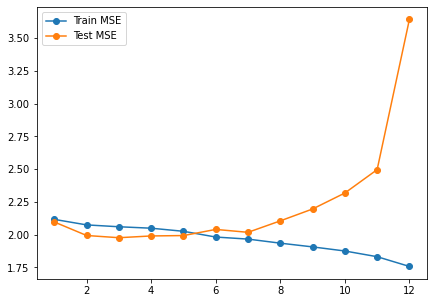

In [0]:
output = pd.DataFrame(columns=['d','Train MSE','Test MSE'])
for i in np.arange(12):
    m = i+1
    Reg = Poly_Reg(X_train_sc, y_train, X_test_sc, y_test, m, fig=False)
    output.loc[i] = [m, Reg['train_MSE'], Reg['test_MSE']]


fig, ax = plt.subplots(figsize=(7,5))
ax.plot(output['d'], np.log(output['Train MSE']), 'o-', label='Train MSE')
ax.plot(output['d'], np.log(output['Test MSE']), 'o-', label='Test MSE')

ax.legend()

## Q3) Ridge and Lasso

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


poly = PolynomialFeatures(degree=2)
Phi_train = poly.fit_transform(X_train_sc)
Phi_test = poly.fit_transform(X_test_sc)
print(Phi_train.shape)
print(Phi_test.shape)

pd.DataFrame(data=Phi_train) # 순서대로 1, x1, x2, x1^2, x2^2, x1x2

(330, 6)
(83, 6)


,0,1,2,3,4,5
0,1.0,-0.134,1.262e+00,0.018,-1.688e-01,1.593e+00
1,1.0,-1.090,-4.570e-01,1.188,4.980e-01,2.088e-01
2,1.0,0.814,8.901e-04,0.662,7.241e-04,7.923e-07
3,1.0,0.778,-5.002e-01,0.605,-3.892e-01,2.502e-01
4,1.0,0.190,4.156e-01,0.036,7.914e-02,1.727e-01
...,...,...,...,...,...,...
325,1.0,1.171,-1.546e-01,1.370,-1.810e-01,2.391e-02
326,1.0,-1.240,1.089e+00,1.538,-1.351e+00,1.187e+00
327,1.0,-0.361,-2.496e-01,0.130,9.015e-02,6.232e-02
328,1.0,0.242,-4.311e-01,0.059,-1.045e-01,1.858e-01


### 1) Ridge Regression

Ridge랑 Lasso 모두 LinearRegression()과 같은 방법.
함수를 객체로 부르기 -> lambda정하기 ->train(모델은 .coef_로 확인) -> .predict(testset)로 예측 

In [0]:
from sklearn.linear_model import Ridge
alphas=np.logspace(-6, 6, 500)

In [0]:
def Ridge_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Ridge?##
    #1. Call Ridge function as an object
    reg = Ridge()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
   
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()

        print("Weight:" ,coefs[np.argmin(test_MSE)])
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE}

Weight: [[ 0.    -8.581 -2.986 -1.489 -0.016  1.761]]


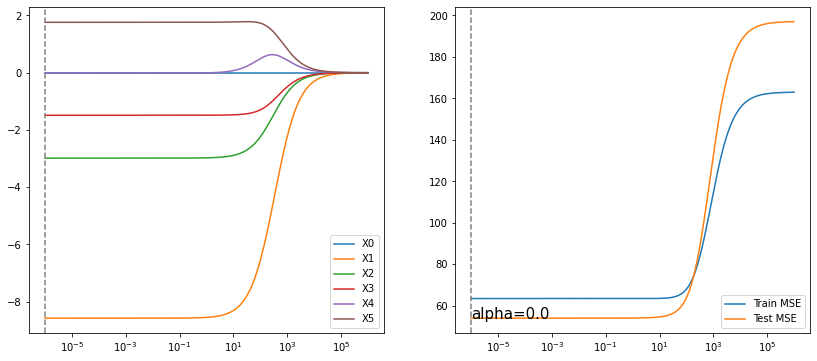

In [0]:
Ridge_output = Ridge_Reg(Phi_train, y_train, Phi_test, y_test, alphas, fig=True)

### 2) LASSO 

In [0]:
from sklearn.linear_model import Lasso
alphas=np.logspace(-6, 6, 500)

In [0]:
def Lasso_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Lasso?##
    #1. Call Lasso function as an object
    reg = Lasso()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
    
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()

        print("Weight:" ,coefs[np.argmin(test_MSE)])
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE}

Weight: [ 0.    -8.581 -2.986 -1.489 -0.016  1.761]


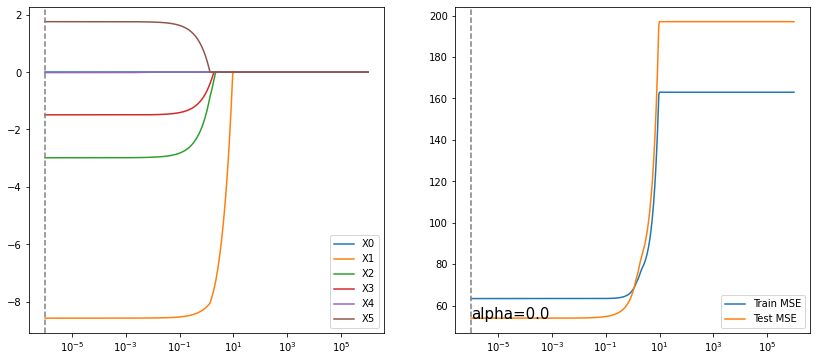

In [0]:
Lasso_output = Lasso_Reg(Phi_train, y_train, Phi_test, y_test, alphas, fig=True)

## Q4) k fold CV for $\lambda$


sklearn에서 kfold 함수는 데이터를 k개의 train-test split으로 나누는 index를 뱉는다. 즉 인덱스만 뱉어주므로 직접 그 인덱스가지고 데이터에서 뽑아내는 것은 직접 해야하는 것. 때문에 미리 데이터를 준비하고, Ridge든 뭐든 자체적으로 만든 함수도 준비해서, for 구문 안에서 끝나도록 해보자.

In [0]:
import numpy as np
from sklearn.model_selection import KFold

kcv = KFold(n_splits=5, shuffle=True)

kcvMSE_Ridge = np.zeros((kcv.get_n_splits(), alphas.size))
kcvMSE_Lasso = np.zeros((kcv.get_n_splits(), alphas.size))

i = 0
for train_index, test_index in kcv.split(Phi_train, y_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape) #just print the shape. printing the indices is quite long
    CV_Phi_train, CV_Phi_test = Phi_train[train_index,:], Phi_train[test_index,:]
    CV_Y_train, CV_Y_test = y_train.iloc[train_index,:], y_train.iloc[test_index,:]
    
    Ridge_output = Ridge_Reg(CV_Phi_train, CV_Y_train, CV_Phi_test, CV_Y_test, alphas, fig=False)
    kcvMSE_Ridge[i, :] = Ridge_output['test_MSE']
    
    Lasso_output = Lasso_Reg(CV_Phi_train, CV_Y_train, CV_Phi_test, CV_Y_test, alphas, fig=False)
    kcvMSE_Lasso[i, :] = Lasso_output['test_MSE']
    i += 1

TRAIN: (264,) TEST: (66,)
TRAIN: (264,) TEST: (66,)
TRAIN: (264,) TEST: (66,)
TRAIN: (264,) TEST: (66,)
TRAIN: (264,) TEST: (66,)


[18.30311675620613]


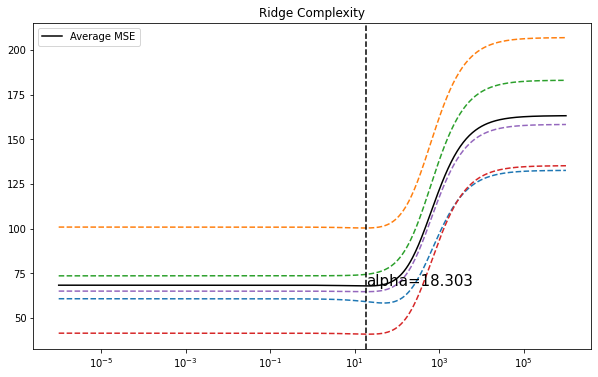

In [0]:
fig, ax= plt.subplots(figsize=(10,6))
#alphas=np.logspace(-6, 6, 500) 
#alpha = -6: almost the same as linreg
#alpha = 6 : very 
meanMSE = np.apply_along_axis(np.mean, 1, kcvMSE_Ridge.T)
ax.plot(alphas, kcvMSE_Ridge.T, linestyle='--')
ax.plot(alphas, meanMSE, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE)],3)
ax.text(alphas[np.argmin(meanMSE)], np.amin(meanMSE), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Ridge Complexity')
ax.legend()

ridge_alpha = [alphas[np.argmin(meanMSE)]] #iterable하게 하려면 상수지만 괄호씌워야함
print(ridge_alpha)


[0.28768540901905915]


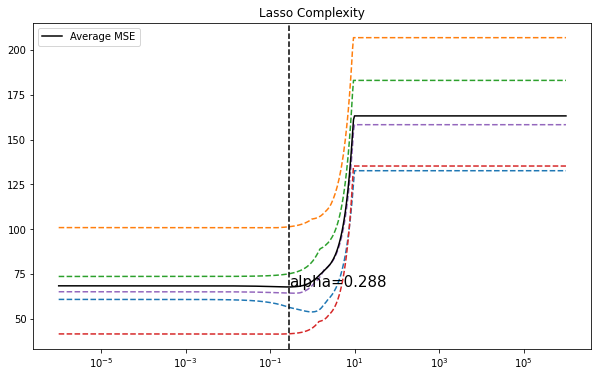

In [0]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE = np.apply_along_axis(np.mean, 1, kcvMSE_Lasso.T)
ax.plot(alphas, kcvMSE_Lasso.T, linestyle='--')
ax.plot(alphas, meanMSE, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE)],3)
ax.text(alphas[np.argmin(meanMSE)], np.amin(meanMSE), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Lasso Complexity')
ax.legend()


lasso_alpha = [alphas[np.argmin(meanMSE)]] #상수지만 괄호씌워야 iterable!
print(lasso_alpha)


많은 triald을 통해서도 alpha = 0이 나오는데 2변수 고차항 모델에서 regularization이 안 됨을 의미한다

## Q5) Test MSE report, Feature Selction

In [0]:
Ridge_output = Ridge_Reg(Phi_train, y_train, Phi_test, y_test, alphas = ridge_alpha,fig = False)
#MSE report
print('Test MSE for Ridge is',Ridge_output['test_MSE'][0])



Lasso_output = Lasso_Reg(Phi_train, y_train, Phi_test, y_test, alphas = lasso_alpha,fig = False)
#MSE report
print('Test MSE for Lasso is',Lasso_output['test_MSE'][0])


Test MSE for Ridge is 55.11490887580684
Test MSE for Lasso is 56.44834560103779


### 무엇을 골라도 거기서 거기인 것을 보았을 때 (이 모델에서 Lasso의 경우 regularization이 거의 없는 모델이라고 봐도 된다) 오히려 Ridge와 Lasso가 필요한 경우가 언제인지 반면교사로 알 수 있겠다


### Ridge, Lasso가 필요한 경우는 column들이 near linearly dependent여서 $X^tX$ 가 almost singular한 경우이다. 그러나 지금 2변수 고차항 모델에서는 이러한 여지가 부족하다고 할 수 있다




참고로, polynomial model의 MSE report는

In [0]:
print('Test MSE for Polynomial Regression is',PRmodel['test_MSE'])

Test MSE for Polynomial Regression is 7.34243572398924


맨 처음 한 Polynomial Regression의 예측오류가 가장 적었는데 이 모델의 계수들을 보자면

In [0]:
PRmodel['coef']

array([[ 3.773e+01, -8.581e+00, -2.986e+00, -1.489e+00, -1.595e-02,
         1.761e+00]])

LASSO의 계수들을 보자면

In [0]:
Ridge_output['coefs']

[array([[ 0.   , -8.106, -2.815, -1.46 ,  0.138,  1.78 ]])]